In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
import os
import h5py
import numpy
import pandas as pd
import pylab as plt
from bilby.core.prior import MultivariateGaussian, MultivariateGaussianDist, PriorDict
import numpy as np
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
import pycbc.conversions as convert
import bilby
import pycbc
import seaborn as sns
import sys
sys.path.append('../')
from utils import load_results_from_h5

## Load FM errors and covariance matrices

In [2]:
base_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
#file_str = 'CE4020ET123_CoBA10_5_PLP_set2_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_5198_events_pop_from_XPHM_det10_opt'
file_str = 'LHI_Asharp_4_PLP_z_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_6716_events_pop_from_XPHM_det10_opt'
fm_err_file = os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Errors',
                           f'{file_str}.h5')
#fm_err_file = os.path.join(base_dir, 'GWBench_analysis', 'BBH', 
#                           'LHI_Asharp_1_PLP_z_MD_zmax_6_lmrd_22_no_spins_all_events_365_days_pop_from_XPHM.h5')

In [3]:
with h5py.File(fm_err_file, 'r') as f:
    print(f['all_inj_params_original'].keys())
    #print(f['all_inj_params_original']['0']['q'][()])

<KeysViewHDF5 ['PSD_H1', 'PSD_I1', 'PSD_L1', 'SNR_H1', 'SNR_I1', 'SNR_L1', 'SNR_mf_H1', 'SNR_mf_I1', 'SNR_mf_L1', 'SNR_mf_from_opt_H1', 'SNR_mf_from_opt_I1', 'SNR_mf_from_opt_L1', 'SNR_mf_from_opt_network', 'SNR_mf_network', 'SNR_network', 'approximant', 'chi_1_in_plane', 'chi_2_in_plane', 'chi_eff', 'chi_p', 'coa_phase', 'cos_spin1_polar', 'cos_spin2_polar', 'dec', 'delta_f', 'distance', 'eta', 'f_final', 'f_lower', 'f_ref', 'inclination', 'inv_q', 'log_distance', 'mass1', 'mass2', 'mchirp', 'mtotal', 'old_index', 'phi_12', 'phi_jl', 'polarization', 'q', 'ra', 'redshift', 'spin1_a', 'spin1_azimuthal', 'spin1_polar', 'spin1x', 'spin1y', 'spin1z', 'spin2_a', 'spin2_azimuthal', 'spin2_polar', 'spin2x', 'spin2y', 'spin2z', 'srcmass1', 'srcmass2', 'srcmchirp', 'srcmtotal', 'theta_jn', 'time_interval', 'trigger_time']>


In [4]:
fm_results = load_results_from_h5(fm_err_file)

In [5]:
num_events = len(fm_results['errors']['chirp_mass'])
num_events

6716

In [6]:
for key,val in fm_results.items():
    if type(val) == dict:
        fm_results[key] = pd.DataFrame(fm_results[key])

In [7]:
for key in fm_results['all_inj_params_original'].keys():
    if 'PSD' in key or 'approximant' in key:
        del fm_results['all_inj_params_original'][key]

## Convert DL to logDL cov matrix

### Convert cov matrices to new cov matrices

In [8]:
from utils import transform_cov_DL_Mc_to_logDL_logMc
DL_idx = fm_results['deriv_variables_in_order'].index('luminosity_distance')
Mc_idx = fm_results['deriv_variables_in_order'].index('chirp_mass')
fm_results['new_cov'] = []
for i in range(len(fm_results['cov'])):
    new_cov = transform_cov_DL_Mc_to_logDL_logMc(fm_results['cov'][i],
                                                 fm_results['inj_params']['luminosity_distance'][i], DL_idx, 
                                                 fm_results['inj_params']['chirp_mass'][i], Mc_idx)
    fm_results['new_cov'].append(new_cov)
fm_results['new_cov'] = np.array(fm_results['new_cov'])
fm_results['new_deriv_variables_in_order'] = []

for var in fm_results['deriv_variables_in_order']:
    if var == 'luminosity_distance' or var == 'chirp_mass':
        fm_results['new_deriv_variables_in_order'].append(f'log_{var}')
    else:
        fm_results['new_deriv_variables_in_order'].append(var)

In [9]:
fm_results['new_deriv_variables_in_order']

['log_chirp_mass',
 'mass_ratio',
 'log_luminosity_distance',
 'theta_jn',
 'phase',
 'geocent_time',
 'ra',
 'dec',
 'psi']

### Sanity check the errors are consistent

In [10]:
fm_results['errors']['log_luminosity_distance'] = fm_results['errors']['luminosity_distance']/fm_results['all_inj_params_original']['distance']
log_DL_idx = list(fm_results['new_deriv_variables_in_order']).index('log_luminosity_distance')

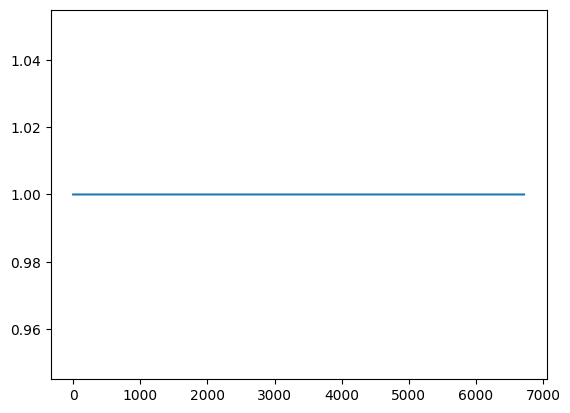

In [11]:
plt.plot([np.sqrt(cov[log_DL_idx, log_DL_idx]) for cov in fm_results['new_cov']]/fm_results['errors']['log_luminosity_distance'])

## Create new means

In [12]:
fm_results['deriv_variables_in_order']

['chirp_mass',
 'mass_ratio',
 'luminosity_distance',
 'theta_jn',
 'phase',
 'geocent_time',
 'ra',
 'dec',
 'psi']

In [13]:
param_bounds = {
    'chirp_mass':[1, np.inf],
    'log_chirp_mass':[0, np.inf],
    'mass_ratio':[1/20, 1],
    'luminosity_distance':[1, np.inf],
    'log_luminosity_distance':[0, np.inf],
    'theta_jn':[0, np.pi],
    'geocent_time':[-np.inf, np.inf],
    'ra':[0, 2*np.pi],
    'dec':[-np.pi/2, np.pi/2],
    'psi':[0, 2*np.pi]
}

if max(fm_results['all_inj_params_original']['coa_phase']) > np.pi:
    param_bounds['phase'] = [0, 2*np.pi]
else:    
    param_bounds['phase'] = [-np.pi, np.pi]

In [14]:
param_bounds

{'chirp_mass': [1, inf],
 'log_chirp_mass': [0, inf],
 'mass_ratio': [0.05, 1],
 'luminosity_distance': [1, inf],
 'log_luminosity_distance': [0, inf],
 'theta_jn': [0, 3.141592653589793],
 'geocent_time': [-inf, inf],
 'ra': [0, 6.283185307179586],
 'dec': [-1.5707963267948966, 1.5707963267948966],
 'psi': [0, 6.283185307179586],
 'phase': [0, 6.283185307179586]}

### Create posterior using jittered mean values for each parameter

In order to induce noise in the posterior, the following steps are followed:
1. Multivariate gaussian (MVG) is created taking true value as mean
2. One random sample is drawn for each parameter from the MVG. This sample becomes the new mean mimicking the effect of gaussian noise.
3. New gaussian is created taking the above value as the new mean

#### Using transformed cov matrices

In [15]:
fm_results['new_deriv_variables_in_order']

['log_chirp_mass',
 'mass_ratio',
 'log_luminosity_distance',
 'theta_jn',
 'phase',
 'geocent_time',
 'ra',
 'dec',
 'psi']

In [16]:
fm_results['inj_params'].loc[:, 'log_luminosity_distance'] = np.log(fm_results['inj_params']['luminosity_distance'])
fm_results['inj_params'].loc[:, 'log_chirp_mass'] = np.log(fm_results['inj_params']['chirp_mass'])

### Check if cov matrices are positive-definite

In [17]:
failed = []
for event in range(len(fm_results['all_inj_params_original'])):
    cov = fm_results['new_cov'][event]  # the covariance matrix
    try:
        np.linalg.cholesky(cov)
    except np.linalg.LinAlgError:
        failed.append(event)

In [18]:
failed

[]

### Get new means

In [19]:
n_events = len(fm_results['new_cov'])
fm_results_updated = {'new_mean_vals': []}
for key, val in fm_results.items():
    if 'variables' in key or 'new_mean' in key:
        continue
    elif isinstance(val, np.ndarray):
        fm_results_updated[key] = []
    elif isinstance(val, pd.DataFrame):
        fm_results_updated[key] = pd.DataFrame(columns=val.columns)

In [20]:
[(key, type(fm_results_updated[key])) for key in fm_results_updated.keys()]

[('new_mean_vals', list),
 ('all_inj_params_original', pandas.core.frame.DataFrame),
 ('cov', list),
 ('errors', pandas.core.frame.DataFrame),
 ('inj_params', pandas.core.frame.DataFrame),
 ('netw_snrs', list),
 ('sky_locs', list),
 ('new_cov', list)]

In [21]:
from numpy.linalg import LinAlgError
import logging

logging.getLogger('bilby').setLevel(logging.ERROR)
failed_convert_posteriors = []

for event in tqdm(range(n_events)):
    mu = [fm_results['inj_params'][param][event] for param in fm_results['new_deriv_variables_in_order']]
    cov = fm_results['new_cov'][event]

    # Symmetrize covariance
    cov = (cov + cov.T) / 2

    # Try constructing the posterior, adding jitter if needed
    for attempt in range(5):
        try:
            mvg = MultivariateGaussianDist(
                fm_results['new_deriv_variables_in_order'],
                mus=mu,
                covs=cov,
                bounds=[param_bounds[param] for param in fm_results['new_deriv_variables_in_order']]
            )
            break
        except LinAlgError:
            # Add increasing jitter
            eps = 1e-12 * (10 ** attempt)
            cov += eps * np.eye(cov.shape[0])
        except ValueError:
            # Add increasing jitter
            eps = 1e-12 * (10 ** attempt)
            cov += eps * np.eye(cov.shape[0])
    else:
        failed_convert_posteriors.append(event)
        continue  # skip this event

    # Sample new mean values
    new_mean_vals = {param: MultivariateGaussian(mvg, param).sample() 
                     for param in fm_results['new_deriv_variables_in_order']}
    fm_results_updated['new_mean_vals'].append(new_mean_vals)
    for key in fm_results_updated.keys():
        if key == 'new_mean_vals':
            continue
        else:
            if isinstance(fm_results_updated[key], pd.DataFrame):
                fm_results_updated[key].loc[event] = fm_results[key].loc[event]
            elif isinstance(fm_results_updated[key], list):
                fm_results_updated[key].append(fm_results[key][event])

if failed_convert_posteriors:
    print(f"Failed to convert events: {failed_convert_posteriors}")

  0%|          | 5/6716 [00:00<02:14, 49.97it/s]

100%|██████████| 6716/6716 [01:07<00:00, 98.92it/s] 

Failed to convert events: [591, 1318, 1731, 1838, 2889, 3035, 3075, 3943, 4914, 5157, 5304, 5308, 6690]


In [22]:
fm_results_updated['all_inj_params_original'].reset_index(inplace=True, drop=True)
fm_results_updated['inj_params'].reset_index(inplace=True, drop=True)
fm_results_updated['errors'].reset_index(inplace=True, drop=True)
fm_results_updated['new_mean_vals'] = pd.DataFrame(fm_results_updated['new_mean_vals'])

In [23]:
[len(fm_results_updated[key]) for key in fm_results_updated.keys()]

[6703, 6703, 6703, 6703, 6703, 6703, 6703, 6703]

Text(0, 0.5, 'Old/New log(DL)')

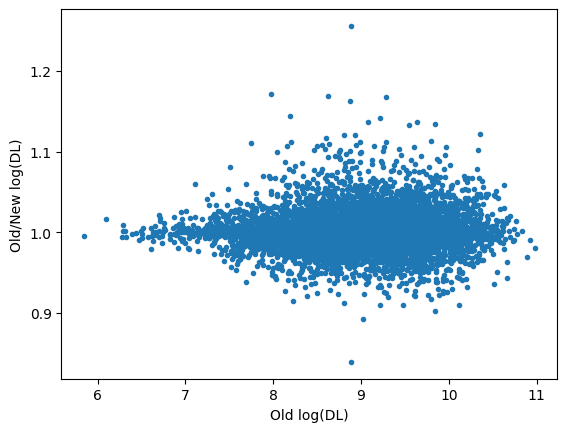

In [24]:
plt.plot(fm_results_updated['inj_params']['log_luminosity_distance'], 
         fm_results_updated['inj_params']['log_luminosity_distance']/fm_results_updated['new_mean_vals']['log_luminosity_distance'], 
         '.');
plt.xlabel('Old log(DL)')
plt.ylabel('Old/New log(DL)')

Text(0, 0.5, 'Old/New DL')

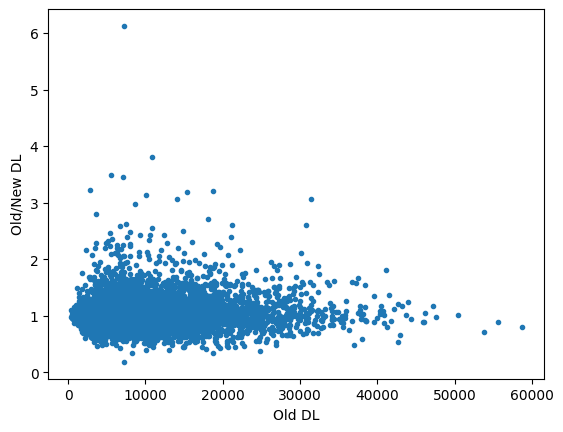

In [25]:
plt.plot(fm_results_updated['inj_params']['luminosity_distance'], 
         fm_results_updated['inj_params']['luminosity_distance']/np.exp(fm_results_updated['new_mean_vals']['log_luminosity_distance']), 
         '.');
plt.xlabel('Old DL')
plt.ylabel('Old/New DL')

Text(0, 0.5, '(Old DL - New DL)*SNR / Old DL')

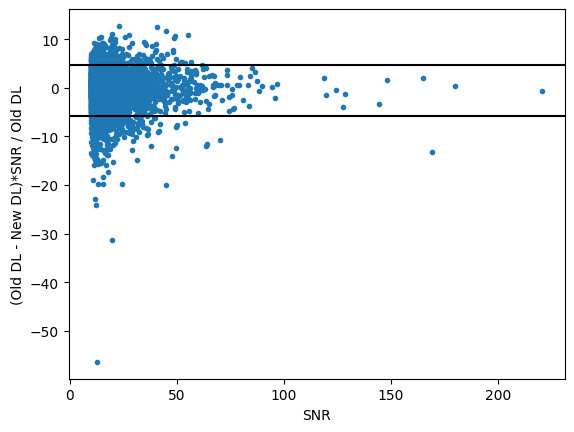

In [26]:
y = (fm_results_updated['inj_params']['luminosity_distance'] - np.exp(fm_results_updated['new_mean_vals']['log_luminosity_distance']))*fm_results_updated['all_inj_params_original']['SNR_network']/fm_results_updated['inj_params']['luminosity_distance']
plt.plot(fm_results_updated['all_inj_params_original']['SNR_network'], y, 
         '.');
plt.axhline(np.percentile(y, 5), c='k')
plt.axhline(np.percentile(y, 95), c='k')
plt.xlabel('SNR')
plt.ylabel('(Old DL - New DL)*SNR / Old DL')

#### Save new means to h5

In [27]:
for key, val in fm_results_updated.items():
    if 'variables' in key:
        continue
    if isinstance(val, list):
        fm_results_updated[key] = np.array(val)

In [28]:
fm_err_file

'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Errors/LHI_Asharp_4_PLP_z_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_6716_events_pop_from_XPHM_det10_opt.h5'

In [29]:
new_fm_file = fm_err_file.replace('.h5', '_with_new_means.h5').replace(str(n_events), str(len(fm_results_updated['new_mean_vals'])))
new_fm_file

'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Errors/LHI_Asharp_4_PLP_z_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_6703_events_pop_from_XPHM_det10_opt_with_new_means.h5'

In [30]:
fm_results_updated.keys()

dict_keys(['new_mean_vals', 'all_inj_params_original', 'cov', 'errors', 'inj_params', 'netw_snrs', 'sky_locs', 'new_cov'])

In [31]:
fm_results_updated['deriv_variables_in_order'] = fm_results['deriv_variables_in_order']
fm_results_updated['new_deriv_variables_in_order'] = fm_results['new_deriv_variables_in_order']

In [32]:
from utils import save_results_to_h5
save_results_to_h5(fm_results_updated, new_fm_file)

#### Check new file has correct keys

In [33]:
with h5py.File(new_fm_file, 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['all_inj_params_original', 'cov', 'deriv_variables_in_order', 'errors', 'inj_params', 'netw_snrs', 'new_cov', 'new_deriv_variables_in_order', 'new_mean_vals', 'sky_locs']>


## Fisher matrix analysis on new means

In [34]:
fm_results_updated.keys()

dict_keys(['new_mean_vals', 'all_inj_params_original', 'cov', 'errors', 'inj_params', 'netw_snrs', 'sky_locs', 'new_cov', 'deriv_variables_in_order', 'new_deriv_variables_in_order'])

In [35]:
pycbc_to_pesummary_map_spins = {
    'spin1_a': 'a_1',
    'spin2_a': 'a_2',
    'spin1_polar': 'tilt_1',
    'spin2_polar':'tilt_2',
    'phi_12': 'phi_12',
    'phi_jl': 'phi_jl',
}

In [36]:
fm_results_updated['new_mean_vals'].loc[:,'chirp_mass'] = np.exp(fm_results_updated['new_mean_vals']['log_chirp_mass'])
fm_results_updated['new_mean_vals'].loc[:,'luminosity_distance'] = np.exp(fm_results_updated['new_mean_vals']['log_luminosity_distance'])

In [37]:
gwfish_input_data2 = {pycbc_to_pesummary_map_spins[key]:fm_results_updated['all_inj_params_original'][key] for key in pycbc_to_pesummary_map_spins.keys()}
for key in fm_results_updated['deriv_variables_in_order']:
    gwfish_input_data2[key] = fm_results_updated['new_mean_vals'][key]
gwfish_input_data2 = pd.DataFrame(gwfish_input_data2)
gwfish_input_data2

,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,chirp_mass,mass_ratio,luminosity_distance,theta_jn,phase,geocent_time,ra,dec,psi
0,0.760636,0.684449,1.022494,0.525412,0.764847,2.904038,158.349432,0.775388,40517.117564,1.983588,0.170842,1.893063e+09,4.854131,-0.722473,0.923646
1,0.394018,0.691163,2.995731,1.633899,1.158571,4.024758,22.381382,0.540918,12453.832880,0.200891,2.560860,1.896530e+09,1.187681,0.223930,3.894964
2,0.610746,0.264523,1.798947,2.157453,5.760831,0.568653,16.976764,0.598461,4032.258590,2.319890,0.450610,1.893988e+09,2.964844,-1.173166,2.576300
3,0.044333,0.325298,1.153914,1.121220,0.313291,1.131370,8.230200,0.844911,1492.148912,1.415262,4.609755,1.897014e+09,1.982234,-0.066929,0.031583
4,0.342275,0.228454,1.309507,2.207805,4.514678,3.967111,122.535837,0.670194,19553.251262,0.495785,5.623728,1.899610e+09,4.264467,0.566475,0.866986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6698,0.696177,0.193392,1.744415,1.307115,0.820274,3.954778,39.640025,0.981680,18855.531745,0.351639,5.815723,1.902950e+09,0.942483,0.497351,0.117255
6699,0.624318,0.961953,1.389584,0.548296,0.289655,0.544910,10.068464,0.363459,5028.640493,2.791796,0.605097,1.909740e+09,4.534757,-0.812682,1.636916
6700,0.926681,0.631055,1.464708,1.332467,3.175070,5.942500,13.413785,0.735475,7492.774242,0.376181,3.922736,1.900745e+09,3.781224,-0.256648,0.233599
6701,0.227559,0.530129,1.492097,0.883078,4.668210,5.112223,28.193217,0.511293,13881.653550,2.857167,3.572982,1.914379e+09,5.282646,0.175931,0.713069


In [38]:
len(fm_results_updated['new_cov'])

6703

In [39]:
file_str = fm_err_file.split('/')[-1].strip('.h5').replace(f'{n_events}_events', f'{len(fm_results_updated["new_cov"])}_events')
file_str

'LHI_Asharp_4_PLP_z_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_6703_events_pop_from_XPHM_det10_opt'

In [40]:
if 'CE4020ET123' in file_str:
    detectors = ['CE1', 'CE2', 'ET']
elif 'LHI' in file_str:
    detectors = ['A_sharp_L', 'A_sharp_H', 'A_sharp_IN']
matrix_file_names = f'{file_str}_fm2'
#matrix_file_names = f'LHI_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_{n_events}_events_pop_from_XPHM_det10_opt'
print(detectors)
print(matrix_file_names)

['A_sharp_L', 'A_sharp_H', 'A_sharp_IN']
LHI_Asharp_4_PLP_z_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_6703_events_pop_from_XPHM_det10_opt_fm2


In [41]:
nprocs = 8
from gwfish_functions import parallel_compute_network_errors, combine_and_archive_fisher_matrices
import GWFish.modules as gwf_mods
import pathlib

In [42]:
fm_results_updated.keys()

dict_keys(['new_mean_vals', 'all_inj_params_original', 'cov', 'errors', 'inj_params', 'netw_snrs', 'sky_locs', 'new_cov', 'deriv_variables_in_order', 'new_deriv_variables_in_order'])

In [43]:
fisher_params = ['chirp_mass', 'mass_ratio', 'luminosity_distance', 'theta_jn', 'phase', 'geocent_time', 'ra', 'dec', 'psi']
network = gwf_mods.detection.Network(detector_ids = detectors, detection_SNR = (0., 0.01), config=pathlib.Path('detectors.yaml'))
fm2_results = {}
_, fm2_results['fm2_netw_snrs'], fm2_results['fm2_errors'], fm2_results['fm2_sky_locs'] = (
    parallel_compute_network_errors(
        network=network,
        gwfish_input_data=gwfish_input_data2,
        fisher_params=fisher_params,
        f_ref=fm_results_updated['all_inj_params_original']['f_ref'][0],
        base_dir=base_dir,
        matrix_file_names=matrix_file_names,
        nproc=nprocs
    )
)

100%|██████████| 838/838 [1:05:19<00:00,  4.68s/it]


In [44]:
combine_and_archive_fisher_matrices(
    base_dir=os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices'),
    matrix_file_prefix=f'fisher_matrices_{matrix_file_names}',
    n_chunks=nprocs,
    output_file=os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices', f'fisher_matrices_{matrix_file_names}.npy')
)

combine_and_archive_fisher_matrices(
    base_dir=os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices'),
    matrix_file_prefix=f'inv_fisher_matrices_{matrix_file_names}',
    n_chunks=nprocs,
    output_file=os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices', f'inv_fisher_matrices_{matrix_file_names}.npy')
)

Combined Fisher matrices saved to /home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Fisher_matrices/fisher_matrices_LHI_Asharp_4_PLP_z_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_6703_events_pop_from_XPHM_det10_opt_fm2.npy
Moved 8 chunked Fisher matrix files to /home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Fisher_matrices/chunks
Combined Fisher matrices saved to /home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Fisher_matrices/inv_fisher_matrices_LHI_Asharp_4_PLP_z_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_6703_events_pop_from_XPHM_det10_opt_fm2.npy
Moved 8 chunked Fisher matrix files to /home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Fisher_matrices/chunks


In [45]:
fm2_results.keys()

dict_keys(['fm2_netw_snrs', 'fm2_errors', 'fm2_sky_locs'])

### Add all params to fm2_results

In [46]:
fm2_results['fm2_all_inj_params'] = gwfish_input_data2
fm2_results['fm2_inj_params'] = gwfish_input_data2[fisher_params]
fm2_results['fm2_errors'] = pd.DataFrame(fm2_results['fm2_errors'], columns=fisher_params)

In [47]:
load_inv_matrices = np.load(os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices', 
                                         f'inv_fisher_matrices_{matrix_file_names}.npy'))

In [48]:
len(load_inv_matrices)

6703

In [49]:
len(fm2_results['fm2_errors'])

6703

In [50]:
[(key, type(val), len(val)) for key, val in fm2_results.items()]

[('fm2_netw_snrs', numpy.ndarray, 6703),
 ('fm2_errors', pandas.core.frame.DataFrame, 6703),
 ('fm2_sky_locs', numpy.ndarray, 6703),
 ('fm2_all_inj_params', pandas.core.frame.DataFrame, 6703),
 ('fm2_inj_params', pandas.core.frame.DataFrame, 6703)]

In [51]:
fm2_results['fm2_cov'] = load_inv_matrices

### Compare new SNRs with old

Text(0, 0.5, 'New/Old SNR')

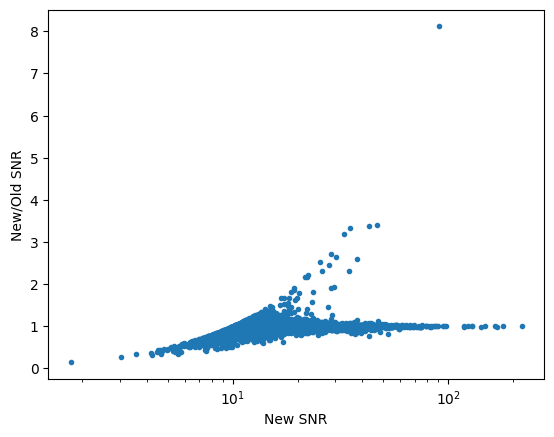

In [52]:
plt.plot(fm2_results['fm2_netw_snrs'], 
         fm2_results['fm2_netw_snrs']/fm_results_updated['all_inj_params_original']['SNR_network'], '.')
plt.xscale('log')
plt.xlabel('New SNR')
plt.ylabel('New/Old SNR')

### Sanity checks

#### Check if cov matrices are positive-definite

In [53]:
failed = []
for event in range(len(fm2_results['fm2_all_inj_params'])):
    cov = load_inv_matrices[event]  # the covariance matrix
    try:
        np.linalg.cholesky(cov)
    except np.linalg.LinAlgError:
        failed.append(event)

In [54]:
failed

[521,
 654,
 782,
 1063,
 1272,
 1385,
 2352,
 2734,
 3613,
 3986,
 4419,
 4573,
 4724,
 4970,
 5174,
 5359,
 5429,
 5665,
 6452,
 6681]

In [55]:
fm2_failed_dict = {}
if len(failed) !=0:
    fm2_failed_dict['fm2_inj_params'] = fm2_results['fm2_inj_params'].loc[failed]
    fm2_failed_dict['fm2_all_inj_params'] = fm2_results['fm2_all_inj_params'].loc[failed]

In [56]:
print(len(fm2_results['fm2_inj_params']))

6703


In [57]:
fm2_results.keys()

dict_keys(['fm2_netw_snrs', 'fm2_errors', 'fm2_sky_locs', 'fm2_all_inj_params', 'fm2_inj_params', 'fm2_cov'])

In [58]:
[(key, type(val), len(val)) for key, val in fm2_results.items()]

[('fm2_netw_snrs', numpy.ndarray, 6703),
 ('fm2_errors', pandas.core.frame.DataFrame, 6703),
 ('fm2_sky_locs', numpy.ndarray, 6703),
 ('fm2_all_inj_params', pandas.core.frame.DataFrame, 6703),
 ('fm2_inj_params', pandas.core.frame.DataFrame, 6703),
 ('fm2_cov', numpy.ndarray, 6703)]

In [59]:
[(key, type(val), len(val)) for key, val in fm_results_updated.items()]

[('new_mean_vals', pandas.core.frame.DataFrame, 6703),
 ('all_inj_params_original', pandas.core.frame.DataFrame, 6703),
 ('cov', numpy.ndarray, 6703),
 ('errors', pandas.core.frame.DataFrame, 6703),
 ('inj_params', pandas.core.frame.DataFrame, 6703),
 ('netw_snrs', numpy.ndarray, 6703),
 ('sky_locs', numpy.ndarray, 6703),
 ('new_cov', numpy.ndarray, 6703),
 ('deriv_variables_in_order', list, 9),
 ('new_deriv_variables_in_order', list, 9)]

In [60]:
fm_results_combined = fm2_results | fm_results_updated

In [61]:
[(key, type(val), len(val)) for key, val in fm_results_combined.items()]

[('fm2_netw_snrs', numpy.ndarray, 6703),
 ('fm2_errors', pandas.core.frame.DataFrame, 6703),
 ('fm2_sky_locs', numpy.ndarray, 6703),
 ('fm2_all_inj_params', pandas.core.frame.DataFrame, 6703),
 ('fm2_inj_params', pandas.core.frame.DataFrame, 6703),
 ('fm2_cov', numpy.ndarray, 6703),
 ('new_mean_vals', pandas.core.frame.DataFrame, 6703),
 ('all_inj_params_original', pandas.core.frame.DataFrame, 6703),
 ('cov', numpy.ndarray, 6703),
 ('errors', pandas.core.frame.DataFrame, 6703),
 ('inj_params', pandas.core.frame.DataFrame, 6703),
 ('netw_snrs', numpy.ndarray, 6703),
 ('sky_locs', numpy.ndarray, 6703),
 ('new_cov', numpy.ndarray, 6703),
 ('deriv_variables_in_order', list, 9),
 ('new_deriv_variables_in_order', list, 9)]

In [62]:
final_fm_results = {}
for key, val in fm_results_combined.items():
    if len(failed) == 0:
        print("No failed events")
        final_fm_results[key] = val
    else:
        if isinstance(val, pd.DataFrame):
            final_fm_results[key] = val.drop(index=failed).reset_index(drop=True)
        elif isinstance(val, np.ndarray):
            final_fm_results[key] = np.array([val[i] for i in range(len(val)) if i not in failed])
        elif isinstance(val, list):
            final_fm_results[key] = val

In [63]:
[(key, type(val), len(val)) for key, val in final_fm_results.items()]

[('fm2_netw_snrs', numpy.ndarray, 6683),
 ('fm2_errors', pandas.core.frame.DataFrame, 6683),
 ('fm2_sky_locs', numpy.ndarray, 6683),
 ('fm2_all_inj_params', pandas.core.frame.DataFrame, 6683),
 ('fm2_inj_params', pandas.core.frame.DataFrame, 6683),
 ('fm2_cov', numpy.ndarray, 6683),
 ('new_mean_vals', pandas.core.frame.DataFrame, 6683),
 ('all_inj_params_original', pandas.core.frame.DataFrame, 6683),
 ('cov', numpy.ndarray, 6683),
 ('errors', pandas.core.frame.DataFrame, 6683),
 ('inj_params', pandas.core.frame.DataFrame, 6683),
 ('netw_snrs', numpy.ndarray, 6683),
 ('sky_locs', numpy.ndarray, 6683),
 ('new_cov', numpy.ndarray, 6683),
 ('deriv_variables_in_order', list, 9),
 ('new_deriv_variables_in_order', list, 9)]

### Choose events with SNR > 12

In [64]:
snr_above_12_mask = final_fm_results['fm2_netw_snrs'] >= 12
fm_results_above_12 = {}
for key in final_fm_results.keys():
    if isinstance(final_fm_results[key], list):
        fm_results_above_12[key] = final_fm_results[key]
    elif isinstance(final_fm_results[key], pd.DataFrame):
        fm_results_above_12[key] = final_fm_results[key].loc[snr_above_12_mask].reset_index(drop=True)
    else:
        fm_results_above_12[key] = final_fm_results[key][snr_above_12_mask]

In [65]:
[(key, type(val), len(val)) for key, val in fm_results_above_12.items()]

[('fm2_netw_snrs', numpy.ndarray, 4504),
 ('fm2_errors', pandas.core.frame.DataFrame, 4504),
 ('fm2_sky_locs', numpy.ndarray, 4504),
 ('fm2_all_inj_params', pandas.core.frame.DataFrame, 4504),
 ('fm2_inj_params', pandas.core.frame.DataFrame, 4504),
 ('fm2_cov', numpy.ndarray, 4504),
 ('new_mean_vals', pandas.core.frame.DataFrame, 4504),
 ('all_inj_params_original', pandas.core.frame.DataFrame, 4504),
 ('cov', numpy.ndarray, 4504),
 ('errors', pandas.core.frame.DataFrame, 4504),
 ('inj_params', pandas.core.frame.DataFrame, 4504),
 ('netw_snrs', numpy.ndarray, 4504),
 ('sky_locs', numpy.ndarray, 4504),
 ('new_cov', numpy.ndarray, 4504),
 ('deriv_variables_in_order', list, 9),
 ('new_deriv_variables_in_order', list, 9)]

#### DL errors are reasonable

Text(0.5, 0, '$\\Delta D_L / D_L$')

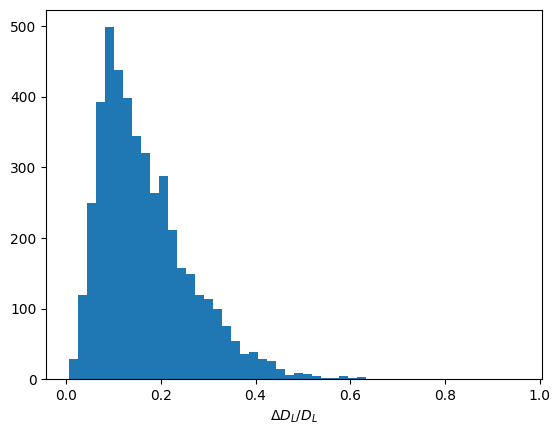

In [66]:
plt.hist(fm_results_above_12['fm2_errors']['luminosity_distance']/fm_results_above_12['fm2_all_inj_params']['luminosity_distance'], bins=50);
plt.xlabel('$\Delta D_L / D_L$')

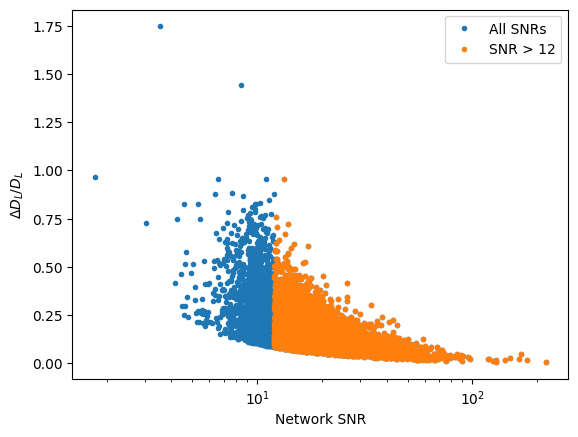

In [67]:
plt.plot(final_fm_results['fm2_netw_snrs'], 
         final_fm_results['fm2_errors']['luminosity_distance']/final_fm_results['fm2_all_inj_params']['luminosity_distance'], '.', 
         label='All SNRs')
plt.plot(fm_results_above_12['fm2_netw_snrs'], 
         fm_results_above_12['fm2_errors']['luminosity_distance']/fm_results_above_12['fm2_all_inj_params']['luminosity_distance'], 
         '.', label='SNR > 12')
plt.ylabel('$\Delta D_L / D_L$')
plt.xlabel('Network SNR')
plt.xscale('log')
plt.legend()

#### Check the recomibing has not messed up matrix orders

In [68]:
dl_idx = list(fm_results_above_12['fm2_errors'].keys()).index('luminosity_distance')
dl_idx

2

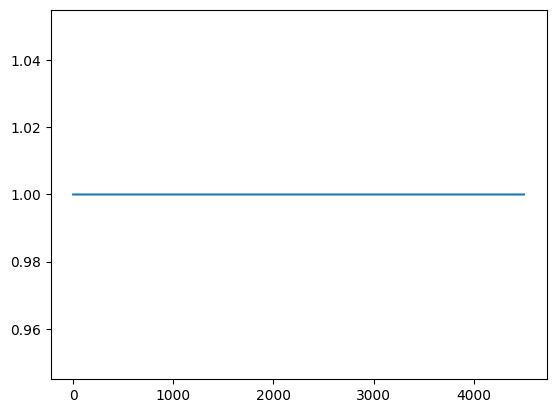

In [69]:
dl_errs_from_covs = [np.sqrt(cov[dl_idx, dl_idx]) for cov in fm_results_above_12['fm2_cov']]
plt.plot(fm_results_above_12['fm2_errors']['luminosity_distance']/dl_errs_from_covs)

### Save new fm values to file

In [70]:
fm_err_file

'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Errors/LHI_Asharp_4_PLP_z_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_6716_events_pop_from_XPHM_det10_opt.h5'

In [71]:
new_fm_file = fm_err_file.replace('det10_opt.h5', 'fm2.h5').replace(str(n_events), str(len(fm_results_above_12['new_mean_vals'])))
new_fm_file

'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Errors/LHI_Asharp_4_PLP_z_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_4504_events_pop_from_XPHM_fm2.h5'

In [72]:
fm_results_above_12.keys()

dict_keys(['fm2_netw_snrs', 'fm2_errors', 'fm2_sky_locs', 'fm2_all_inj_params', 'fm2_inj_params', 'fm2_cov', 'new_mean_vals', 'all_inj_params_original', 'cov', 'errors', 'inj_params', 'netw_snrs', 'sky_locs', 'new_cov', 'deriv_variables_in_order', 'new_deriv_variables_in_order'])

In [73]:
from utils import save_results_to_h5
save_results_to_h5(fm_results_above_12, new_fm_file)

#### Check new file has correct keys

In [74]:
with h5py.File(new_fm_file, 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['all_inj_params_original', 'cov', 'deriv_variables_in_order', 'errors', 'fm2_all_inj_params', 'fm2_cov', 'fm2_errors', 'fm2_inj_params', 'fm2_netw_snrs', 'fm2_sky_locs', 'inj_params', 'netw_snrs', 'new_cov', 'new_deriv_variables_in_order', 'new_mean_vals', 'sky_locs']>


## Convert DL to logDL in fm2_cov matrices

In [75]:
fm_results_above_12['fm2_inj_params'].keys()

Index(['chirp_mass', 'mass_ratio', 'luminosity_distance', 'theta_jn', 'phase',
       'geocent_time', 'ra', 'dec', 'psi'],
      dtype='object')

In [76]:
DL_idx = fm_results_above_12['deriv_variables_in_order'].index('luminosity_distance')
Mc_idx = fm_results_above_12['deriv_variables_in_order'].index('chirp_mass')
fm_results_above_12['fm2_new_cov'] = []
for i in range(len(fm_results_above_12['fm2_cov'])):
    new_cov = transform_cov_DL_Mc_to_logDL_logMc(fm_results_above_12['fm2_cov'][i],
                                                 fm_results_above_12['fm2_inj_params']['luminosity_distance'][i], DL_idx, 
                                                 fm_results_above_12['fm2_inj_params']['chirp_mass'][i], Mc_idx)
    fm_results_above_12['fm2_new_cov'].append(new_cov)
fm_results_above_12['fm2_new_cov'] = np.array(fm_results_above_12['fm2_new_cov'])

In [77]:
fm_results_above_12.keys()

dict_keys(['fm2_netw_snrs', 'fm2_errors', 'fm2_sky_locs', 'fm2_all_inj_params', 'fm2_inj_params', 'fm2_cov', 'new_mean_vals', 'all_inj_params_original', 'cov', 'errors', 'inj_params', 'netw_snrs', 'sky_locs', 'new_cov', 'deriv_variables_in_order', 'new_deriv_variables_in_order', 'fm2_new_cov'])

### Sanity check the errors are consistent

In [78]:
fm_results_above_12['fm2_errors']['log_luminosity_distance'] = fm_results_above_12['fm2_errors']['luminosity_distance'] / \
                                                                fm_results_above_12['fm2_all_inj_params']['luminosity_distance']
log_DL_idx = list(fm_results_above_12['new_deriv_variables_in_order']).index('log_luminosity_distance')

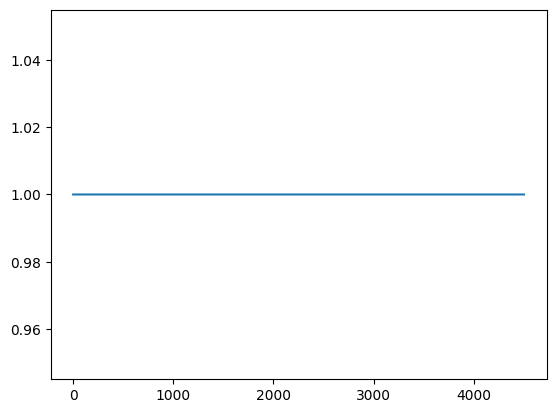

In [79]:
plt.plot([np.sqrt(cov[log_DL_idx, log_DL_idx]) for cov in fm_results_above_12['fm2_new_cov']]/fm_results_above_12['fm2_errors']['log_luminosity_distance'])

## Create posteriors with parallelization

In [80]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import numpy as np
from numpy.linalg import LinAlgError


def process_event(event, data, params, param_bounds, n_samples, mean_vals_key, cov_key):
    """
    Process a single event: build Gaussian dist and sample.
    Returns (event_key, samples, failed_info).
    """
    mu = [data[mean_vals_key][param][event] for param in params]
    cov = data[cov_key][event]  # covariance matrix

    # Symmetrize covariance
    cov = (cov + cov.T) / 2

    mvg = None
    for attempt in range(5):
        try:
            mvg = MultivariateGaussianDist(
                params, mus=mu, covs=cov,
                bounds=[param_bounds[param] for param in params]
            )
            break  # success
        except LinAlgError:
            # Add increasing jitter
            eps = 1e-12 * (10 ** attempt)
            cov += eps * np.eye(cov.shape[0])
        except ValueError:
            # Add increasing jitter
            eps = 1e-12 * (10 ** attempt)
            cov += eps * np.eye(cov.shape[0])

    if mvg is None:  # all attempts failed
        failed_info = {
            "event": event,
            "params": {p: data[mean_vals_key][p][event] for p in params},
            "error": "LinAlgError after jitter attempts",
        }
        return f'event_{event}', None, failed_info

    # If we succeed, sample posteriors
    posterior_samples_i = {}
    for param in ['log_chirp_mass', 'mass_ratio', 'log_luminosity_distance']:
        posterior_d = MultivariateGaussian(mvg, param)
        posterior_samples_i[param] = posterior_d.sample(n_samples)

    return f'event_{event}', posterior_samples_i, None


def parallel_sampling(data, params, param_bounds, n_samples, mean_vals_key, cov_key, nproc=4):
    """
    Parallel sampling across events with failure logging.
    """
    n_events = len(data[cov_key])
    results_list = [None] * n_events
    failed_events = []

    with ProcessPoolExecutor(max_workers=nproc) as executor:
        futures = {
            executor.submit(process_event, event, data, params, param_bounds, n_samples, mean_vals_key, cov_key): event
            for event in range(n_events)
        }

        for future in tqdm(as_completed(futures), total=n_events):
            event_key, samples, failed_info = future.result()
            idx = int(event_key.split("_")[1])
            results_list[idx] = (event_key, samples)

            if failed_info is not None:
                failed_events.append(failed_info)

    # Filter out None entries before unpacking
    posterior_samples_all_events = {
        k: v for kv in results_list if kv is not None for k, v in [kv]
    }

    return posterior_samples_all_events, failed_events

In [81]:
fm_results_above_12.keys()

dict_keys(['fm2_netw_snrs', 'fm2_errors', 'fm2_sky_locs', 'fm2_all_inj_params', 'fm2_inj_params', 'fm2_cov', 'new_mean_vals', 'all_inj_params_original', 'cov', 'errors', 'inj_params', 'netw_snrs', 'sky_locs', 'new_cov', 'deriv_variables_in_order', 'new_deriv_variables_in_order', 'fm2_new_cov'])

In [82]:
posterior_samples_all_events, failed_events = parallel_sampling(
    data=fm_results_above_12,
    params=fm_results_above_12['new_deriv_variables_in_order'],
    param_bounds=param_bounds,
    n_samples=10000,
    mean_vals_key='new_mean_vals',
    cov_key='fm2_new_cov',
    nproc=8  # adjust to number of CPU cores
)

100%|██████████| 4504/4504 [4:12:11<00:00,  3.36s/it]   


In [83]:
failed_events

[{'event': 538,
  'params': {'log_chirp_mass': 4.492364258877251,
   'mass_ratio': 0.6221269749308204,
   'log_luminosity_distance': 9.983402967611601,
   'theta_jn': 3.0631123085841625,
   'phase': 1.6586137425233967,
   'geocent_time': 1903612705.8806763,
   'ra': 3.4160541973519614,
   'dec': -0.6196927444970157,
   'psi': 0.0240145955787171},
  'error': 'LinAlgError after jitter attempts'},
 {'event': 614,
  'params': {'log_chirp_mass': 4.168962909170192,
   'mass_ratio': 0.7919883259231386,
   'log_luminosity_distance': 9.285684097417539,
   'theta_jn': 0.05896512783986503,
   'phase': 1.8475512743152778,
   'geocent_time': 1912171760.2780776,
   'ra': 3.275116471703848,
   'dec': 0.8753024881791417,
   'psi': 2.8793776294422306},
  'error': 'LinAlgError after jitter attempts'},
 {'event': 883,
  'params': {'log_chirp_mass': 2.9989315209065586,
   'mass_ratio': 0.6515507776362257,
   'log_luminosity_distance': 8.655081737862176,
   'theta_jn': 0.023811407756642422,
   'phase': 0.6

In [84]:
len(posterior_samples_all_events)

4504

In [85]:
if len(failed_events) == 0:
    print("No failed events")
else:
    for ev in failed_events:
        posterior_samples_all_events.pop(f'event_{ev["event"]}')

In [86]:
len(posterior_samples_all_events)

4493

##### Add Mc and DL from log_Mc and log_DL

In [87]:
posterior_samples_all_events['event_0'].keys()

dict_keys(['log_chirp_mass', 'mass_ratio', 'log_luminosity_distance'])

In [88]:
for event in posterior_samples_all_events.keys():
    posterior_samples_all_events[event]['chirp_mass'] = np.exp(posterior_samples_all_events[event]['log_chirp_mass'])
    posterior_samples_all_events[event]['luminosity_distance'] = np.exp(posterior_samples_all_events[event]['log_luminosity_distance'])

### Add m1, m2, q, z

In [89]:
for event in tqdm(posterior_samples_all_events.keys()):
    Mc = posterior_samples_all_events[event]['chirp_mass']
    q = posterior_samples_all_events[event]['mass_ratio']
    DL = posterior_samples_all_events[event]['luminosity_distance']
    posterior_samples_all_events[event]['mass_1'] = convert.mass1_from_mchirp_q(Mc, 1/q)
    posterior_samples_all_events[event]['mass_2'] = convert.mass2_from_mchirp_q(Mc, 1/q)
    posterior_samples_all_events[event]['redshift'] = pycbc.cosmology.redshift(DL, cosmology='Planck18')

100%|██████████| 4493/4493 [00:10<00:00, 414.21it/s]


#### Add source frame parameters

In [90]:
for event in posterior_samples_all_events.keys():
    for param in ['mass_1', 'mass_2', 'chirp_mass']:
        posterior_samples_all_events[event][param+'_source'] = posterior_samples_all_events[event][param]/(1 + posterior_samples_all_events[event]['redshift'])

In [91]:
posterior_samples_all_events['event_0'].keys()

dict_keys(['log_chirp_mass', 'mass_ratio', 'log_luminosity_distance', 'chirp_mass', 'luminosity_distance', 'mass_1', 'mass_2', 'redshift', 'mass_1_source', 'mass_2_source', 'chirp_mass_source'])

### Save all posteriors to h5 file

In [92]:
len(posterior_samples_all_events)

4493

In [93]:
file_str = fm_err_file.split('/')[-1].replace('_no_spins', 
                                              '_no_spins_posteriors_10K').replace(str(n_events), 
                                                                                  str(len(posterior_samples_all_events))).replace('_det10_opt.h5', '_fm2.h5')
file_str

'LHI_Asharp_4_PLP_z_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_posteriors_10K_4493_events_pop_from_XPHM_fm2.h5'

In [94]:
events_posterior_file = os.path.join(base_dir, 'event_posterior_files', 'BBH', 'CE4020ET123', 'GWFish', file_str)
#events_posterior_file = os.path.join(base_dir, 'event_posterior_files', 'BBH', 'Asharp', 'GWFish',
#                        f'LHI_Asharp_5_PLP_z_fref_10_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_posteriors_10K_{len(posterior_samples_all_events)}_events_pop_from_XPHM.h5')
events_posterior_file

'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/event_posterior_files/BBH/CE4020ET123/GWFish/LHI_Asharp_4_PLP_z_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_posteriors_10K_4493_events_pop_from_XPHM_fm2.h5'

In [95]:
save_results_to_h5(posterior_samples_all_events, events_posterior_file)

## Considering only redshift posterior for gwpop analysis

### Create prior on redshift

$p(z)dz = p(\log D_L) d(\log D_L)$

Since the posteriors were drawn from a Multivariate Gaussian created on $\log\mathcal{M}_c$, $q$, and $\log D_L$, the priors are uniform on these parameters.

Hence,

$p(z) = p(\log D_L) \frac{1}{D_L} \left| \frac{dD_L(z)}{dz} \right| \propto \frac{1}{D_L} \left| \frac{dD_L(z)}{dz} \right|$

since $p(log(D_L)) = const$

In [96]:
def calc_dDL_dz(DL_arr, z_arr):
    """
    Parameters: 
    ----------------------
    z_arr: numpy array
        redshift value
    DL_arr: numpy array
        Luminosity distance (Mpc)

    Returns:
    --------------------------
    dDL_dz : scipy.interpolate.UnivariateSpline
        Derivative spline giving dDL/dz
    """
    
    sort_idx = np.argsort(DL_arr)
    DL_sorted = DL_arr[sort_idx]
    z_sorted = z_arr[sort_idx]
    
    fDL = UnivariateSpline(z_sorted, DL_sorted, s=0)
    dfDL_dz = fDL.derivative()
    return(dfDL_dz)

In [97]:
DL_grid = np.linspace(1, 13e4, 10000)
z_grid = pycbc.cosmology.redshift(DL_grid, cosmology='Planck18')
print('z_max =', z_grid.max())
dDL_dz_interp = calc_dDL_dz(DL_grid, z_grid)

z_max = 11.979426122089338


In [98]:
posteriors_z_list = []
for event in tqdm(posterior_samples_all_events):
    zi = posterior_samples_all_events[event]['redshift']
    DLi = posterior_samples_all_events[event]['luminosity_distance']
    prior_zi = dDL_dz_interp(zi)/DLi
    #prior_zi_normalized = prior_zi/np.trapz(prior_zi, zi)
    prior_zi_normalized = prior_zi/np.sum(prior_zi)
    event_i = {'redshift': zi,
               'prior': prior_zi_normalized}
    posteriors_z_list.append(pd.DataFrame(event_i))

100%|██████████| 4493/4493 [00:09<00:00, 462.56it/s]


### Plot the priors

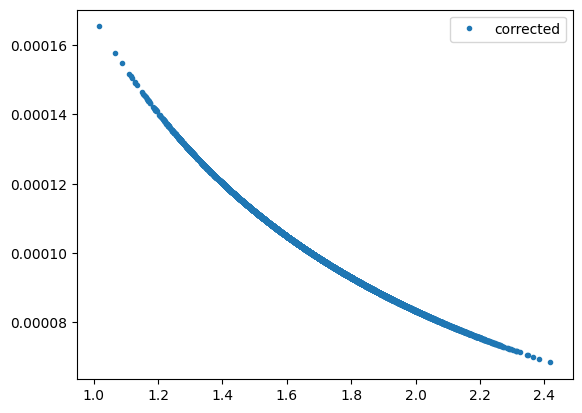

In [99]:
plt.plot(zi, prior_zi_normalized, '.', label='corrected')
plt.legend(loc=1)

### Save to pickle file

In [100]:
num_events

6716

In [101]:
len(posterior_samples_all_events)

4493

In [102]:
file_str = events_posterior_file.split('/')[-1].replace('_posteriors', '_z_posteriors').replace('.h5', '.pkl')
file_str

'LHI_Asharp_4_PLP_z_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_z_posteriors_10K_4493_events_pop_from_XPHM_fm2.pkl'

In [103]:
# commented out to avoid accidental overwriting
pd.to_pickle(posteriors_z_list, os.path.join(base_dir, 'gwpopulation', 'BBH', 'posteriors_from_GWFish', file_str))
#pd.to_pickle(posteriors_z_list, os.path.join(base_dir, 'gwpopulation', 'BBH', 'posteriors_from_GWFish',
#                        f'LHI_Asharp_5_PLP_z_fref_10_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_z_posteriors_10K_{len(posterior_samples_all_events)}_events_365_days_pop_from_XPHM.pkl'))